In [ ]:
!pip install scikit-image

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import morphology
from skimage.measure import label

## Сегментация водораздела (англ. Watershed Segmentation)

##### это один из самых популярных алгоритмов сегментации изображений, обычно используемый, когда мы хотим решить одну из самых сложных операций в обработке изображений — разделение похожих объектов на изображении, которые соприкасаются друг с другом. Чтобы было это легко понять, представьте изображение в градациях серого как топографическую поверхность, и на этом изображении значения пикселей с высокой интенсивностью представляют собой пики (белые области), тогда как значения с низкой интенсивностью представляют долины — локальные минимумы (черные области).



##### Итак, представьте теперь, что начинаем заполнять всю долину водой, и через некоторое время вода, поступающая из разных долин, начнет сливаться. Чтобы этого избежать, нужно построить барьеры в местах слияния воды, поэтому барьеры называются линиями бассейна и используются для определения границ сегмента. Когда заливка воды наполняется с самого высокого пика, мы останавливаем заливку водой. В конце процесса будут видны только линии водораздела, и это будет окончательный результат сегментации. Таким образом, целью водораздела является выявление линий водораздела и сегментированного изображения.


In [ ]:
coins = cv2.imread('coins.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(coins, cmap='gray')

In [ ]:
_, thresh_global = cv2.threshold(coins, 127, 255, cv2.THRESH_BINARY)
plt.imshow(thresh_global, cmap='gray')

In [ ]:
img_bitwise=cv2.bitwise_not(thresh_global)
plt.imshow(img_bitwise, cmap='gray')

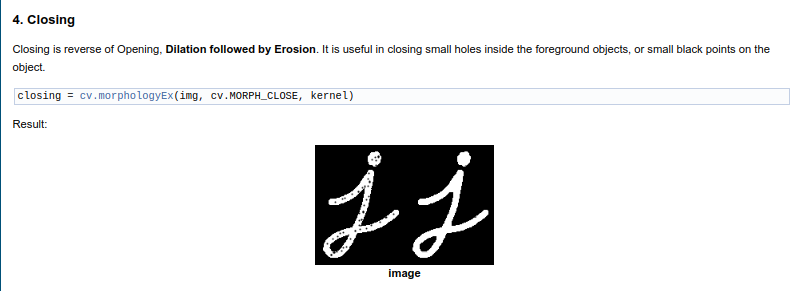

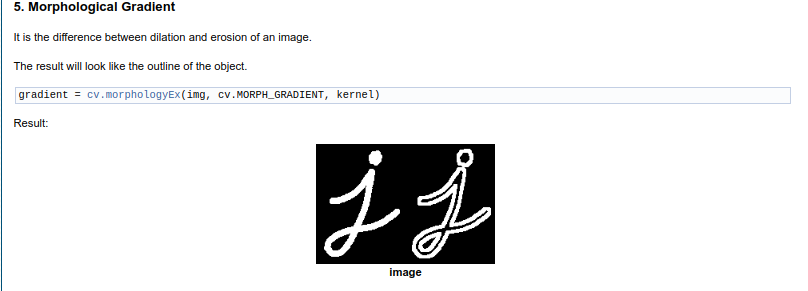

In [ ]:
def printImgs(imgs):
    fig = plt.figure(figsize=(8,24), dpi=250)
    img_len = len(imgs)
    for idx, img in enumerate(imgs):
        fig.add_subplot(img_len, 1, idx + 1)
        plt.imshow(img, cmap='gray')

In [ ]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
cross_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
kernel = np.ones((6, 6), np.uint8)

kernels = [ellipse_kernel, cross_kernel, rect_kernel, kernel]

plots = list()
for k in kernels:
    closing = cv2.morphologyEx(img_bitwise, cv2.MORPH_CLOSE, k)
    plots.append(closing)

printImgs(plots)

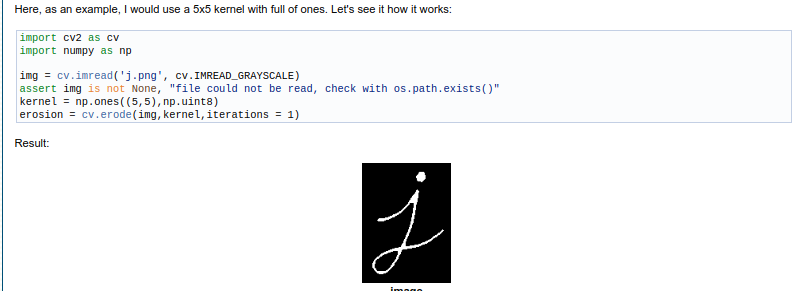

In [ ]:
plots = list()
for k in kernels:
    erosion = cv2.erode(img_bitwise, kernel, iterations = 10)
    closing = cv2.morphologyEx(img_bitwise, cv2.MORPH_CLOSE, k)
    plots.append(closing)

printImgs(plots)

In [ ]:
plt.rcParams['figure.dpi'] = 200

In [ ]:
# Морфологическое закрытие - MORPH_CLOSE
closing = cv2.morphologyEx(img_bitwise, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')

##### Теперь нужно попытаться разделить соприкасающиеся объекты и создать границу между ними. Идея состоит в том, чтобы создать границу как можно дальше от центров перекрывающихся объектов. Затем мы воспользуемся техникой, называемой преобразованием расстояния. Это оператор, который обычно принимает двоичные изображения в качестве входных данных, а интенсивность пикселей точек внутри областей переднего плана заменяется их расстоянием до ближайшего пикселя с нулевой интенсивностью (фоновый пиксель). Для этого мы можем использовать функцию distance_transform_edt() из библиотеки scipy. Эта функция вычисляет точное преобразование евклидова расстояния:

### distance = ndi.distance_transform_edt(binary_img)


In [ ]:
# Точное преобразование евклидова расстояния.
# Эта функция вычисляет преобразование расстояния входных данных, заменяя каждый элемент переднего плана (ненулевой)
# его кратчайшим расстоянием до фона (любой элемент с нулевым значением).

# В дополнение к преобразованию расстояния можно рассчитать преобразование объекта.
# В этом случае индекс ближайшего к каждому элементу переднего плана элемента фона возвращается в отдельном массиве.

distance = ndi.distance_transform_edt(closing)
plt.imshow(distance, cmap='gray')

##### Обратите внимание, что в преобразовании расстояния мы можем видеть белые пиксели, близкие к центру, эти пиксели имеют большее значение преобразования расстояния. Теперь нам нужно найти координаты пиков (локальных максимумов) белых областей на изображении. Для этого будем использовать функцию peak_local_max() из библиотеки scikit-image. Мы применим эту функцию к нашему изображению distance, и на выходе получим координаты локальных максимумов, которые будут использоваться в функции водораздела.

### local_max = peak_local_max(distance, min_distance=50)


In [ ]:
local_max = peak_local_max(distance, min_distance=40)
local_max.shape[0]

In [ ]:
# Отобразите изображение с точками максимумов
plt.imshow(distance, cmap='gray')
plt.scatter(local_max[:, 1], local_max[:, 0], color='red', marker='o', s=10)  # Отметьте точки красными кругами
plt.title('Image with Local Maxima')
plt.show()

##### Следующим шагом является маркировка полученных значений для функции водораздела. Для этого воспользуемся функцией ndi.label() из библиотеки SciPy. Эта функция состоит из одного входного параметра, который представляет собой объект, подобный массиву, который нужно пометить. Любые ненулевые значения этого параметра считаются признаками, а нулевые значения считаются фоном. В нашей программе будем использовать координаты рассчитанного локального максимума. Переведем эти координаты в двумерный массив и функцией ndi.label()и случайным образом пометим все локальные максимумы разными положительными значениями, начиная с 1. Таким образом, если у нас получится 10 объектов на изображении, каждый из них будет помечен значением от 1 до 10.

### mask = np.zeros(distance.shape, dtype=bool)
### mask[tuple(local_max.T)] = True
### markers, _ = ndi.label(mask)


In [ ]:
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(local_max.T)] = True
markers, _ = ndi.label(mask)

In [ ]:
from scipy.ndimage.morphology import grey_dilation, generate_binary_structure, iterate_structure

strct = np.full((15, 15), True)

In [ ]:
# Создайте изображение с черным фоном
image = np.zeros_like(markers, dtype=np.uint8)

# Установите белые точки на изображении
image[markers > 0] = 255

# Отобразите изображение
plt.imshow(image, cmap='gray')

# Добавьте числа рядом с белыми точками
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        if markers[i, j] > 0:
            grey_dilation(image, footprint = strct, mode='wrap')
            plt.text(j, i, str(markers[i, j]), color='white', ha='left', va='center')

plt.title('Image with Numbers')
plt.show()

In [ ]:
result_segmentation = watershed(-distance, markers, mask=closing)

In [ ]:
# Укажите цвета для каждого объекта (от 1 до 52)
colors = np.random.rand(3)

# Отобразите каждый объект на изображении
image = np.zeros(result_segmentation.shape + (3,))
for i in range(1, 53):
    image[result_segmentation == i] = np.random.rand(3)

# Отобразите изображение
plt.imshow(image)
plt.show()

In [ ]:
for label in np.unique(result_segmentation):
    if label == 0:
        continue
    mask = np.zeros(closing.shape, dtype="uint8")
    mask[result_segmentation == label] = 255
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    cv2.drawContours(coins, cnts, -1, (0,255,0), 3)

In [ ]:
plt.imshow(coins)

In [ ]:
plt.imshow(coins, cmap='gray')

In [ ]:
my_oranges = cv2.imread('mnm.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(my_oranges, cmap='gray')

In [ ]:
_, thresh_global = cv2.threshold(my_oranges, 50, 255, cv2.THRESH_BINARY)
# img_bitwise=cv2.bitwise_not(thresh_global) - не нужно
img_bitwise = thresh_global
plt.imshow(thresh_global, cmap='gray')

In [ ]:
img_bitwise

In [ ]:
kernel = np.ones((7, 7), np.uint8)
 # Морфологическое закрытие
tmp = cv2.dilate(img_bitwise, kernel, iterations = 1)
tmp = cv2.erode(tmp, kernel, iterations = 3)
closing = cv2.morphologyEx(tmp, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')

In [ ]:
distance = ndi.distance_transform_edt(closing, distances=120)
plt.imshow(distance, cmap='gray')

In [ ]:
local_max = peak_local_max(distance, min_distance=30)
local_max.shape[0]

In [ ]:
plt.imshow(distance, cmap='gray')
plt.scatter(local_max[:, 1], local_max[:, 0], color='red', marker='o', s=20)  # Отметьте точки красными кругами
plt.title('Image with Local Maxima')
plt.show()

In [ ]:
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(local_max.T)] = True
markers, _ = ndi.label(mask)

In [ ]:
# Создайте изображение с черным фоном
image = np.zeros_like(markers, dtype=np.uint8)

# Установите белые точки на изображении
image[markers > 0] = 255

# Отобразите изображение
plt.imshow(image, cmap='gray')

# Добавьте числа рядом с белыми точками
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        if markers[i, j] > 0:
            grey_dilation(image, footprint = strct, mode='wrap')
            plt.text(j, i, str(markers[i, j]), color='white', ha='left', va='center')

plt.title('Image with Numbers')
plt.show()

In [ ]:
result_segmentation = watershed(-distance, markers, mask=closing)

In [ ]:
# Укажите цвета для каждого объекта (от 1 до 10)
colors = np.random.rand(3)

# Отобразите каждый объект на изображении
image = np.zeros(result_segmentation.shape + (3,))
for i in range(1, 10):
    image[result_segmentation == i] = np.random.rand(3)

# Отобразите изображение
plt.imshow(image)
plt.show()

In [ ]:
for label in np.unique(result_segmentation):
    if label == 0:
        continue
    mask = np.zeros(closing.shape, dtype="uint8")
    mask[result_segmentation == label] = 255
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    cv2.drawContours(my_oranges, cnts, -1, (150,0,0), 20)

In [ ]:
plt.imshow(my_oranges, cmap='gray')